# Code
...
# Imports

In [1]:
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt

# User Configuration

In [36]:
SAVE_FIGS = True  # Save figures

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

DATA_DIR = Path("../../data")
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)

# Utility Functions

## Load Data & Assign Correct Datatypes

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

## Boxenplots (Numeric Values)

In [38]:
def plot_metric_comparison(
    df_real: pd.DataFrame,
    df_synth: pd.DataFrame,
    metric_col: str = 'heart_rate',
    type_col: str = 'type',
    synth_metric_col: str = None,
    figsize: tuple = (4, 6),
    title: str = None,
    lower_bound: float = None,
    upper_bound: float = None,
    yticks_step: float = 10
):
    """
    Vergleicht real- vs. synthetische Verteilungen einer Metrik mithilfe eines Boxen-Plots.

    Parameters
    ----------
    df_real : pd.DataFrame
        DataFrame mit den realen Messwerten. Muss Spalte `metric_col` und `type_col` enthalten.
    df_synth : pd.DataFrame
        DataFrame mit den synthetischen Messwerten. 
        Wenn `synth_metric_col` angegeben ist, wird diese auf `metric_col` umbenannt.
        Muss zusätzlich Spalte `type_col` enthalten.
    metric_col : str, default 'heart_rate'
        Name der Ziel-Spalte in `df_real` (und in `df_synth` nach Umbenennen).
    type_col : str, default 'type'
        Name der Spalte, nach der auf der x-Achse gruppiert wird.
    synth_metric_col : str, optional
        Ursprünglicher Name der Messspalte in `df_synth`. 
        Wenn None (Default), wird angenommen, dass sie schon `metric_col` heißt.
    figsize : tuple, default (4, 6)
        Größe der Abbildung (Breite, Höhe) in Zoll.
    title : str, optional
        Titel der Grafik. Wenn None, wird `metric_col` verwendet.
    lower_bound : float, optional
        Untere Begrenzung der y-Achse.
    upper_bound : float, optional
        Obere Begrenzung der y-Achse.
    yticks_step : float, default 10
        Schrittweite für die y-Achsen-Ticks, falls `lower_bound` und `upper_bound` gesetzt sind.

    Returns
    -------
    fig, ax : matplotlib Figure und Axes
        Objekte der erstellten Abbildung und Achse, falls weitere Feineinstellungen nötig sind.
    """
    # --- 1) Synthetische Daten vorbereiten ---
    # ggf. umbenennen
    if synth_metric_col is not None and synth_metric_col != metric_col:
        df_temp = df_synth[[synth_metric_col, type_col]].copy()
        df_temp = df_temp.rename(columns={synth_metric_col: metric_col})
    else:
        df_temp = df_synth[[metric_col, type_col]].copy()
    
    # zusammenführen
    df_concat = pd.concat(
        [df_real[[metric_col, type_col]], df_temp[[metric_col, type_col]]],
        ignore_index=True
    )
    
    # --- 2) Plot erzeugen ---
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxenplot(
        data=df_concat,
        x=type_col,
        y=metric_col,
        hue=type_col,
        ax=ax,
        linecolor='white',
        linewidth=1.5,
        width=0.6,
        line_kws=dict(linewidth=1.5, color='black'),
        flier_kws=dict(linewidth=0.25, s=5),
        dodge=False
    )
    
    # Achsen-Ticks feinjustieren
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    
    # Achsenbegrenzung und Ticks
    if lower_bound is not None and upper_bound is not None:
        ax.set_ylim(lower_bound, upper_bound)
        ax.set_yticks(np.arange(lower_bound, upper_bound + yticks_step, yticks_step))
    
    # obere/rechte Rahmenlinien entfernen
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Titel setzen
    ax.set_title(title or metric_col)
    
    plt.tight_layout()
 
    return fig, ax


# Main Routine
## Daten Laden

In [5]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)

In [6]:
df_real['type'] = 'Real'
df_synth['type'] = 'Synthetisch'

## Age

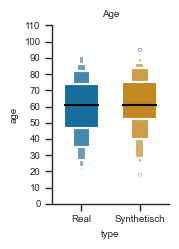

In [39]:
fig, ax = plot_metric_comparison(
    df_real=df_real,
    df_synth=df_synth,
    metric_col='age',
    type_col='type',
    figsize=(1.8, 2.5),
    title='Age',
    lower_bound=0,
    upper_bound=110,
    yticks_step=10
)

plt.show()
if SAVE_FIGS:
    fig.savefig(OUTPUT_DIR_FIG / f"age.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## Heart Rate

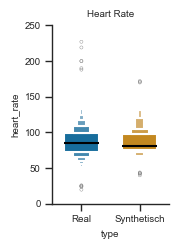

In [40]:
fig, ax = plot_metric_comparison(
    df_real=df_real,
    df_synth=df_synth,
    metric_col='heart_rate',
    type_col='type',
    figsize=(1.8, 2.5),
    title='Heart Rate',
    lower_bound=0,
    upper_bound=240,
    yticks_step=50
)

plt.show()
if SAVE_FIGS:
    fig.savefig(OUTPUT_DIR_FIG / f"heart_rate.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## Respiratory Rate

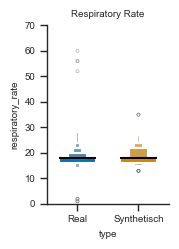

In [41]:
fig, ax = plot_metric_comparison(
    df_real=df_real,
    df_synth=df_synth,
    metric_col='respiratory_rate',
    type_col='type',
    figsize=(1.8, 2.5),
    title='Respiratory Rate',
    lower_bound=0,
    upper_bound=61,
    yticks_step=10
)

plt.show()
if SAVE_FIGS:
    fig.savefig(OUTPUT_DIR_FIG / f"respiratory_rate.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## Oxygen Saturation

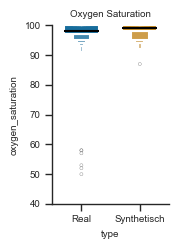

In [42]:
fig, ax = plot_metric_comparison(
    df_real=df_real,
    df_synth=df_synth,
    metric_col='oxygen_saturation',
    type_col='type',
    figsize=(1.8, 2.5),
    title='Oxygen Saturation',
    lower_bound=40,
    upper_bound=100,
    yticks_step=10
)

plt.show()
if SAVE_FIGS:
    fig.savefig(OUTPUT_DIR_FIG / f"oxygen_saturation.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## Temperature

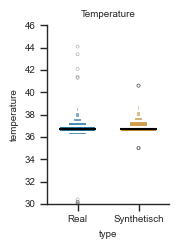

In [43]:
fig, ax = plot_metric_comparison(
    df_real=df_real,
    df_synth=df_synth,
    metric_col='temperature',
    type_col='type',
    figsize=(1.8, 2.5),
    title='Temperature',
    lower_bound=30,
    upper_bound=45,
    yticks_step=2
)

plt.show()
if SAVE_FIGS:
    fig.savefig(OUTPUT_DIR_FIG / f"temperature.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## Systolic BP

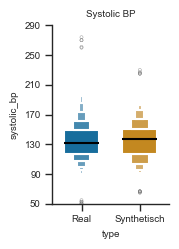

In [44]:
fig, ax = plot_metric_comparison(
    df_real=df_real,
    df_synth=df_synth,
    metric_col='systolic_bp',
    type_col='type',
    figsize=(1.8, 2.5),
    title='Systolic BP',
    lower_bound=50,
    upper_bound=290,
    yticks_step=40
)

plt.show()
if SAVE_FIGS:
    fig.savefig(OUTPUT_DIR_FIG / f"systolic_bp.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

## Diastolic BP

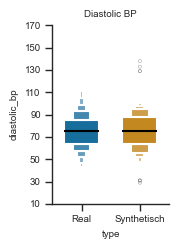

In [45]:
fig, ax = plot_metric_comparison(
    df_real=df_real,
    df_synth=df_synth,
    metric_col='diastolic_bp',
    type_col='type',
    figsize=(1.8, 2.5),
    title='Diastolic BP',
    lower_bound=10,
    upper_bound=160,
    yticks_step=20
)

plt.show()
if SAVE_FIGS:
    fig.savefig(OUTPUT_DIR_FIG / f"diastolic_bp.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)